# Soil Texture Analysis and Raster Processing

In [45]:
!unzip ../CREST_parameters/250mSoils.zip -d ../CREST_parameters/

Archive:  ../CREST_parameters/250mSoils.zip
 extracting: ../CREST_parameters/250mSoils/Ghana_BDRICM_M_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl1_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl2_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl3_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl4_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl5_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl6_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_CLYPPT_M_sl7_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_SNDPPT_M_sl1_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_SNDPPT_M_sl2_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_SNDPPT_M_sl3_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_SNDPPT_M_sl4_250m.tif  
 extracting: ../CREST_parameters/250mSoils/Ghana_SNDPPT_M_sl5_250m.tif  
 extracting

## Step 1: Resample the grids if needed


To 

In [11]:
!pip install rasterio

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import rasterio
import os
import matplotlib.pyplot as plt
import glob
import rasterio
from rasterio.enums import Resampling

In [ ]:
### new 0.0008333333334400000155 (90m)

# Define new resolution
new_res = 0.0008333333334400000155  # Target pixel size in degrees

def resample(file, name_output):
    # Open original raster
    with rasterio.open(file) as src:
        # Compute new dimensions
        scale_factor = src.transform.a / new_res
        new_width = int(src.width * scale_factor)
        new_height = int(src.height * scale_factor)
        
        # Update transform
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
    
        # Read and resample
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear  # Use Resampling.nearest for categorical data
        )
    
        # Update metadata
        new_meta = src.meta.copy()
        new_meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })
    
        # Save new raster
        with rasterio.open(name_output, "w", **new_meta) as dst:
            dst.write(data)
    
    print(f"Resampling completed: {name_output}")


In [ ]:
files = glob.glob(os.path.join(input_path, "*"))
#print(files)

for f in files:
    resample(f, f[len(input_path):] )

Resampling completed: Ghana_SNDPPT_M_sl2_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl7_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl5_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl3_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl6_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl1_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl4_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl2_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl7_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl5_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl3_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl6_250m.tif
Resampling completed: Ghana_BDRICM_M_250m.tif
Resampling completed: Ghana_SNDPPT_M_sl1_250m.tif
Resampling completed: Ghana_CLYPPT_M_sl4_250m.tif


## Step 2: Define Configuration Parameters

In [67]:
# Define file paths
cDomain = 'Ghana'
output_folder = '../CREST_parameters/' # create a new folder
input_path = '../CREST_parameters/90mSoils/'

#If you are using Google colab, create two new folders to place your files
# cDomain = 'Ghana'
# output_folder = '/content/crest_parameters/'
# input_path = '/content/input/'

# Depths in cm
depths = [0, 5, 15, 30, 60, 100, 200]

## Step 3: Define Utility Functions
### Load and Validate Image

In [68]:
def load_and_validate_image(file_path):
    """
    Reads a GeoTIFF file and validates its values.
    Values below 0 or above 200 are replaced with NaN.
    """
    try:
        with rasterio.open(file_path) as src:
            data = src.read(1).astype(float)
            data[(data < 0) | (data > 200)] = np.nan
        return data
    except Exception as e:
        raise FileNotFoundError(f"Error loading {file_path}: {e}")

### Calculate Average Sand and Clay

In [69]:
def calculate_simple_averages(depths, input_path, cDomain):
    """
    Computes weighted averages of sand and clay content across depths.
    """
    depth_avg_sand = None
    depth_avg_clay = None

    for dp in range(len(depths)):
        # Build paths for the current images
        sand_path = os.path.join(input_path, f"{cDomain}_SNDPPT_M_sl{dp+1}_250m.tif")
        clay_path = os.path.join(input_path, f"{cDomain}_CLYPPT_M_sl{dp+1}_250m.tif")

        # Load and validate the current images
        curr_sand = load_and_validate_image(sand_path)
        curr_clay = load_and_validate_image(clay_path)

        if depth_avg_sand is None:
            # Initialize averages with the first layer
            depth_avg_sand = curr_sand
            depth_avg_clay = curr_clay
        else:
            # Update weighted averages
            depth_avg_sand = (depth_avg_sand * dp + curr_sand) / (dp + 1)
            depth_avg_clay = (depth_avg_clay * dp + curr_clay) / (dp + 1)

    return depth_avg_sand, depth_avg_clay

### Classify Soil Texture

In [70]:
def classify_soil_texture(mean_sand, mean_clay):
    """
    Classifies soil texture based on sand and clay percentages.
    The percentage of silt is calculated as 100 - (sand + clay).

    :param mean_sand: Array or value of sand percentage
    :param mean_clay: Array or value of clay percentage
    :return: Array with soil classification based on specified categories
    """

    #Calculate silt
    mean_silt = 100 - (mean_sand + mean_clay)

    # Ensure percentages sum to 100
    if np.any(mean_sand + mean_clay > 100):
        raise ValueError("Sand and clay percentages cannot exceed 100%.")

    # Create an array for classification
    texture_array = np.full_like(mean_sand, fill_value=np.nan, dtype=np.float32)

    # Classification
    texture_array[(mean_silt + 1.5 * mean_clay < 15)] = 1  # Sand
    texture_array[(mean_silt + 1.5 * mean_clay >= 15) & (mean_silt + 2 * mean_clay < 30)] = 2  # Loamy Sand
    texture_array[
        ((mean_clay >= 7) & (mean_clay < 20) & (mean_sand > 52) & (mean_silt + 2 * mean_clay >= 30)) |
        ((mean_clay < 7) & (mean_silt < 50) & (mean_silt + 2 * mean_clay >= 30))
    ] = 3  # Sandy Loam
    texture_array[(mean_clay >= 7) & (mean_clay < 27) & (mean_silt >= 28) & (mean_silt < 50) & (mean_sand <= 52)] = 4  # Loam
    texture_array[
        ((mean_silt >= 50) & (mean_clay >= 12) & (mean_clay < 27)) |
        ((mean_silt >= 50) & (mean_silt < 80) & (mean_clay < 12))
    ] = 5  # Silt Loam
    texture_array[(mean_silt >= 80) & (mean_clay < 12)] = 6  # Silt
    texture_array[(mean_clay >= 20) & (mean_clay < 35) & (mean_silt < 28) & (mean_sand > 45)] = 7  # Sandy Clay Loam
    texture_array[(mean_clay >= 27) & (mean_clay < 40) & (mean_sand > 20) & (mean_sand <= 45)] = 8  # Clay Loam
    texture_array[(mean_clay >= 27) & (mean_clay < 40) & (mean_sand <= 20)] = 9  # Silty Clay Loam
    texture_array[(mean_clay >= 35) & (mean_sand > 45)] = 10  # Sandy Clay
    texture_array[(mean_clay >= 40) & (mean_silt >= 40)] = 11  # Silty Clay
    texture_array[(mean_clay >= 40) & (mean_sand <= 45) & (mean_silt < 40)] = 12  # Clay

    return texture_array

### Calculate Soil Parameters

In [71]:
def calculate_soil_parameters(soil_texture, bed_rock_distance):
    Wm = np.full_like(soil_texture, fill_value=np.nan, dtype=np.float32)
    Fc_Ksat = np.full_like(soil_texture, fill_value=np.nan, dtype=np.float32)
    b = np.full_like(soil_texture, fill_value=np.nan, dtype=np.float32)

    for texture_class, params in SOIL_PARAMETERS.items():
        mask = soil_texture == texture_class
        Wm[mask] = params['eff_porosity'] * 10 * bed_rock_distance[mask] if params['eff_porosity'] else np.nan
        Fc_Ksat[mask] = params['hydraulic_cond'] * 10 if params['hydraulic_cond'] else np.nan
        b[mask] = params['b'] if params['b'] else np.nan

    return Wm, Fc_Ksat, b

### Save Raster Output

In [72]:
def save_raster(data, profile, output_path):
    profile.update(dtype=rasterio.float32, nodata=-9999)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    print(f"The raster layer has been successfully saved at: {output_path}")

## Step 4: Define Soil Parameters

In [73]:
SOIL_PARAMETERS = {
    1: {'eff_porosity': 0.417, 'hydraulic_cond': 11.78, 'b': 2.79},  # Sand
    2: {'eff_porosity': 0.401, 'hydraulic_cond': 2.99, 'b': 4.26},   # Loamy Sand
    3: {'eff_porosity': 0.412, 'hydraulic_cond': 1.09, 'b': 4.74},   # Sandy Loam
    4: {'eff_porosity': 0.4349, 'hydraulic_cond': 0.34, 'b': 5.25},  # Loam
    5: {'eff_porosity': 0.486, 'hydraulic_cond': 0.65, 'b': 5.33},   # Silt Loam
    6: {'eff_porosity': 0.330, 'hydraulic_cond': 0.15, 'b': 7.22},   # Silt
    7: {'eff_porosity': 0.330, 'hydraulic_cond': 0.15, 'b': 6.77},   # Sandy Clay Loam
    8: {'eff_porosity': 0.309, 'hydraulic_cond': 0.1, 'b': 8.17},    # Clay Loam
    9: {'eff_porosity': 0.432, 'hydraulic_cond': 0.1, 'b': 8.72},    # Silty Clay Loam
    10: {'eff_porosity': 0.321, 'hydraulic_cond': 0.06, 'b': 10.73}, # Sandy Clay
    11: {'eff_porosity': 0.423, 'hydraulic_cond': 0.05, 'b': 10.39}, # Silty Clay
    12: {'eff_porosity':  0.385, 'hydraulic_cond': 0.03, 'b': 11.55},# Clay
}

# Main execution

In [74]:
#You can verify if the layers have been readed correctly
files = glob.glob(os.path.join(input_path, "*"))
print(files)

['../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl5_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl7_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl2_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl4_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl1_250m.tif', '../CREST_parameters/90mSoils/Ghana_BDRICM_M_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl6_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl3_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl5_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl7_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl2_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl4_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl1_250m.tif', '../CREST_parameters/90mSoils/Ghana_CLYPPT_M_sl6_250m.tif', '../CREST_parameters/90mSoils/Ghana_SNDPPT_M_sl3_250m.tif']


In [75]:
# Load the "bed rock distance" layer
bed_rock_path = os.path.join(input_path, f"{cDomain}_BDRICM_M_250m.tif")
bed_rock_distance = load_and_validate_image(bed_rock_path)

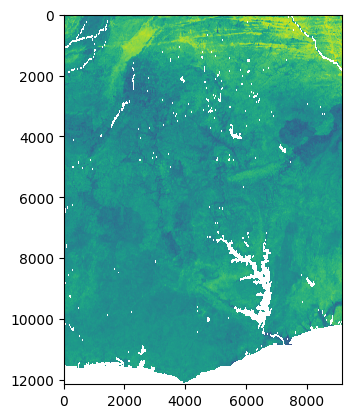

In [76]:
depth_avg_sand, depth_avg_clay = calculate_simple_averages(depths, input_path, cDomain)

#Visualize the outputs (optional)
plt.imshow(depth_avg_sand)

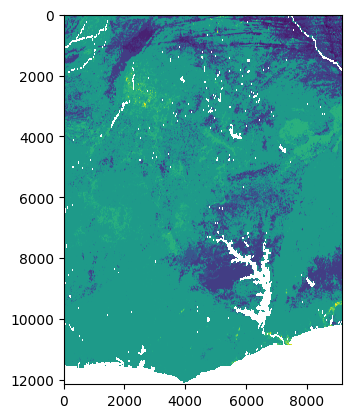

In [77]:
soil_texture = classify_soil_texture(depth_avg_sand, depth_avg_clay)

#Visualize the outputs (optional)
plt.imshow(soil_texture)

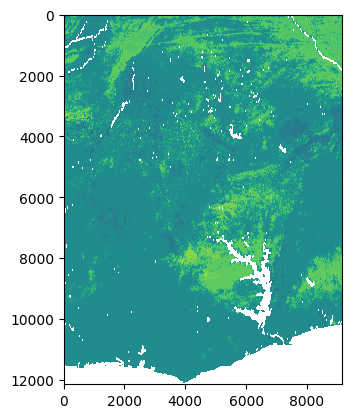

In [78]:
Wm, Fc_Ksat, b = calculate_soil_parameters(soil_texture, bed_rock_distance)

plt.imshow(Wm)

In [79]:
# Save results
with rasterio.open(os.path.join(input_path, f"{cDomain}_SNDPPT_M_sl1_250m.tif")) as src:
    profile = src.profile
    save_raster(Wm, profile, os.path.join(output_folder, "crest_Wm.tif"))
    save_raster(Fc_Ksat, profile, os.path.join(output_folder, "crest_Fc_Ksat.tif"))
    save_raster(b, profile, os.path.join(output_folder, "crest_b.tif"))

    #optional
    # save_raster(depth_avg_sand, profile, os.path.join(output_folder, "depth_avg_sand.tif"))
    # save_raster(depth_avg_clay, profile, os.path.join(output_folder, "depth_avg_clay.tif"))
    # save_raster(soil_texture, profile, os.path.join(output_folder, "soil_texture.tif"))

The raster layer has been successfully saved at: ../CREST_parameters/crest_Wm.tif
The raster layer has been successfully saved at: ../CREST_parameters/crest_Fc_Ksat.tif
The raster layer has been successfully saved at: ../CREST_parameters/crest_b.tif
